In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
import numpy as np
import torch
import pandas as pd
import random
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras as keras
from tensorflow.keras import regularizers

In [ ]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('./data/fin.csv', encoding='latin-1')
file_data = train_df.drop(columns = ['Country'])[20:]

file_target = file_data.drop(columns = ['Year'])

train_data, test_data, train_targets, test_targets = train_test_split(file_data, file_target, test_size=0.1)

In [ ]:
train_targets

<Axes: >

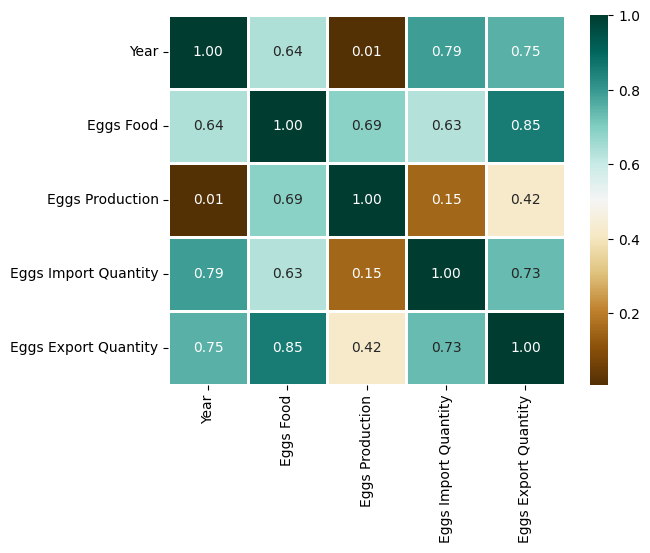

In [ ]:
train_df = pd.read_csv('./data/fin.csv', encoding='latin-1')
train_data = train_df.drop(columns = ['Country'])

import seaborn as sns

sns.heatmap(train_data.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

data = pd.read_csv('./data/fin.csv', encoding='latin-1').drop(columns = ['Country'])
# Calculating VIF
vif = pd.DataFrame()
vif["variables"] = data.columns
vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

print(vif)

              variables          VIF
0                  Year   516.218559
1             Eggs Food  1009.562039
2       Eggs Production    89.050075
3  Eggs Import Quantity     5.263112
4  Eggs Export Quantity    16.910866


In [ ]:
train_df = pd.read_csv('./data/fin.csv', encoding='latin-1')
train_data = train_df.drop(columns = ['Country'])

train_data_arr = []
train_targets_arr = []

test_data_arr = []
test_target_arr = []
r = random.randint(0,10)
k=0
valueRange = 0

for i in range(1,len(train_data)):

  for j in range(i-1,i - valueRange - 1,-1):
    if(j<=0):
      continue
    data_row = train_data[i-1:i]
    data_row.at[i-1, 'Year'] = 1990 + j
    if k == 11:
      r = random.randint(0,10)
      k=0
    if k == r:
      test_data_arr.append(data_row.copy())
      target_row = train_data[j-1:j]
      test_target_arr.append(target_row.drop(columns = ['Year']))
      k+=1
      continue
    k+=1
    train_data_arr.append(data_row.copy())
    target_row = train_data[j-1:j]
    train_targets_arr.append(target_row.drop(columns = ['Year']))

  for j in range(i,len(train_data)):
    data_row = train_data[i-1:i]
    data_row.at[i-1, 'Year'] = 1990 + j
    if k == 11:
      r = random.randint(0,10)
      k=0
    if k == r:
      test_data_arr.append(data_row.copy())
      target_row = train_data[j:j+1]
      test_target_arr.append(target_row.drop(columns = ['Year']))
      k+=1
      continue
    k+=1
    train_data_arr.append(data_row.copy())
    target_row = train_data[j:j+1]
    train_targets_arr.append(target_row.drop(columns = ['Year']))
    if j-i > valueRange-1:
      break

train_targets = pd.concat(train_targets_arr)
train_data = pd.concat(train_data_arr)

test_targets = pd.concat(test_target_arr)
test_data = pd.concat(test_data_arr)

In [ ]:
train_data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_features = scaler.transform(train_data)
train_data = pd.DataFrame(data = scaled_features)

scaled_features = scaler.transform(test_data)
test_data = pd.DataFrame(data = scaled_features)

In [ ]:
train_data_np = train_data.to_numpy()
train_targets_np = train_targets.to_numpy()

test_data_np = test_data.to_numpy()
test_targets_np = test_targets.to_numpy()

In [ ]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
def build_model():
  model = Sequential()
  model.add(Dense(256, input_shape=(5, ), activation='relu', name='dense_1'))
  model.add(Dense(128, activation='relu', name='dense_2'))
  model.add(Dense(64, activation='relu', name='dense_3'))
  model.add(Dense(4, activation='linear', name='dense_output'))


  model.compile(optimizer='Adam', loss='mae', metrics=[root_mean_squared_error])
  return model

In [ ]:
model = build_model()
history = model.fit(
    train_data_np,
    train_targets_np,
    epochs=120,
    batch_size=1,
    verbose=2,
    validation_data=(test_data_np, test_targets_np),
    shuffle=True
)

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:

data = {'Year': [4], 'Alcoholic Beverages Food': [9753.0], 'Alcoholic Beverages Domestic supply quantity': [9762.0],
        'Alcoholic Beverages Production': [8979.0], 'Alcoholic Beverages Import Quantity': [959.0], 'Alcoholic Beverages Export Quantity': [478.0]}

input_data = pd.DataFrame(data)

scaler.fit(input_data)
scaled_features = scaler.transform(input_data)
input_data = pd.DataFrame(data = scaled_features)

pred = model.predict(input_data.to_numpy())
print(pred)

from sklearn.metrics import mean_absolute_percentage_error

result = {'Alcoholic Beverages Food': [10129.0], 'Alcoholic Beverages Domestic supply quantity': [10415.0],
        'Alcoholic Beverages Production': [9552.0], 'Alcoholic Beverages Import Quantity': [1474.0], 'Alcoholic Beverages Export Quantity': [601.0]}

output_data = pd.DataFrame(result)

print(mean_absolute_percentage_error(output_data.to_numpy(), pred))

pred = model.predict(test_data_np)
print(mean_absolute_percentage_error(test_targets_np, pred))



In [ ]:
!pip install shap

In [ ]:
import shap
shap.initjs()

import matplotlib.pyplot as plt


explainer = shap.KernelExplainer(model, test_data_np)
shap_values = explainer.shap_values(test_data_np)

class_names = ['Food', 'Production', 'Import Quantity', 'Export Quantity']

for index, value in enumerate(shap_values):
  shap.summary_plot(
      value,
      train_data_np,
      plot_type='bar',
      feature_names = ['Year','Food', 'Production', 'Import Quantity', 'Export Quantity'],
      show=False
  )

  plt.title(class_names[index])
  plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

x = []
y = []

for i in range(10, 100, 10):

  model = build_model()
  model.fit(
    train_data_np,
    train_targets_np,
    epochs=i,
    batch_size=16,
    verbose=0
  )
  x.append(i)
  pred = model.predict(test_data_np)
  error = mean_absolute_percentage_error(test_targets_np, pred)
  print(error)
  y.append(error)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x, y)
print(y)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
pred = model.predict(test_data_np)
print(mean_absolute_percentage_error(test_targets_np, pred))

print(pred)
print(test_targets_np)
pred/test_targets_np


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(
    train_data_np,
    train_targets_np
)
pred = lr_model.predict(test_data_np)

print(mean_absolute_percentage_error(test_targets_np, pred))
pred/test_targets_np

In [ ]:
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(n_estimators=100, criterion = 'friedman_mse')
rf_model.fit(
    train_data_np,
    train_targets_np
)
pred = rf_model.predict(test_data_np)

print(mean_absolute_percentage_error(test_targets_np, pred))
pred/test_targets_np

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

kr_model = KNeighborsRegressor(n_neighbors=6)
kr_model.fit(
    train_data_np,
    train_targets_np
)
pred = kr_model.predict(test_data_np)

print(mean_absolute_percentage_error(test_targets_np, pred))
pred/test_targets_np

In [ ]:
from sklearn.linear_model import MultiTaskLassoCV

la_model = MultiTaskLassoCV(cv=5, random_state=0)
la_model.fit(
    train_data_np,
    train_targets_np
)

pred = la_model.predict(test_data_np)

print(mean_absolute_percentage_error(test_targets_np, pred))
pred/test_targets_np

In [ ]:
from sklearn.linear_model import RidgeCV

ri_model = RidgeCV()
ri_model.fit(
    train_data_np,
    train_targets_np
)
pred = ri_model.predict(test_data_np)

print(mean_absolute_percentage_error(test_targets_np, pred))
pred/test_targets_np

In [ ]:
model_results

In [ ]:
train_df = pd.read_csv('./data/fin.csv', encoding='latin-1')
train_data = train_df.drop(columns = ['Country']).tail(5)

last_year_data_arr = []
last_year_targets_arr = []

valueRange = 0

for i in range(1,len(train_data)):

  for j in range(i,len(train_data)):
    data_row = train_data.head(i).tail(1)
    data_row.at[i+25, 'Year'] = (int)(2015 + j)
    last_year_data_arr.append(data_row.copy())
    target_row = train_data[j:j+1]
    last_year_targets_arr.append(target_row.drop(columns = ['Year']))
    if j-i > valueRange-1:
      break

last_year_targets = pd.concat(last_year_targets_arr)
last_year_data = pd.concat(last_year_data_arr)

scaler2 = MinMaxScaler()
scaler2.fit(last_year_data)
scaled_features2 = scaler2.transform(last_year_data)
last_year_data = pd.DataFrame(data = scaled_features2)

last_year_data_np = last_year_data.to_numpy()
last_year_targets_np = last_year_targets.to_numpy()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
pred = model.predict(last_year_data_np)
print('2 hiden layears err = {}'.format(mean_absolute_percentage_error(last_year_targets_np, model.predict(last_year_data_np))))
print('LinearRegression err = {}'.format(mean_absolute_percentage_error(last_year_targets_np, lr_model.predict(last_year_data_np))))
print('RandomForestRegressor err = {}'.format(mean_absolute_percentage_error(last_year_targets_np, rf_model.predict(last_year_data_np))))
print('KNeighborsRegressor err = {}'.format(mean_absolute_percentage_error(last_year_targets_np, kr_model.predict(last_year_data_np))))
print('MultiTaskLassoCV err = {}'.format(mean_absolute_percentage_error(last_year_targets_np, la_model.predict(last_year_data_np))))
print('RidgeCV err = {}'.format(mean_absolute_percentage_error(last_year_targets_np, ri_model.predict(last_year_data_np))))

In [ ]:
data = {'Year': [2020], 'Eggs Food': [2238.0],
        'Eggs Production': [2388.0], 'Eggs Import Quantity': [99.0],
       'Eggs Export Quantity': [15.0] }

data = {'Year': [1999], 'Eggs Food': [1981.0],
        'Eggs Production': [2033.0], 'Eggs Import Quantity': [9.0],
       'Eggs Export Quantity': [7.0]}

input_data = pd.DataFrame(data)

scaled_features = scaler.transform(input_data)
input_data = pd.DataFrame(data = scaled_features)
input_data_np = input_data.to_numpy()

pred = model.predict(input_data_np)
print(pred)

lr_pred = lr_model.predict(input_data_np)
print(lr_pred)

rf_pred = rf_model.predict(input_data_np)
print(rf_pred)

kr_pred = kr_model.predict(input_data_np)
print(kr_pred)